<a href="https://colab.research.google.com/github/FunkyDonkey065/Facade_aesthetic_evaluator/blob/main/FAST_AI_ML_test_facade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install packages\
image retrieving funciton

In [1]:
!pip install -U ddgs
!pip install -U fastcore
!pip install -U fastbook

from ddgs import DDGS
from fastcore.all import *
from fastbook import *


def search_images(keywords, max_images=200):
  return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

Test search

In [141]:
urls = search_images('good building exterior', max_images=2)
urls[1]

'https://pics.craiyon.com/2023-09-24/2e14c508823b4e29a5a1e1bb91f22d6e.webp'

download the image according to the url (beautiful facade)




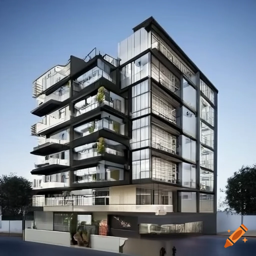

In [142]:
from fastdownload import download_url
dest = 'images_test1.jpg'
download_url(urls[1], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)


download the image according to the url (ugly facade)

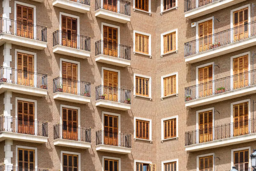

In [144]:
download_url(search_images('common building exterior', max_images=1)[0], 'images_test2.jpg', show_progress=False)
im = Image.open('images_test2.jpg')
im.to_thumb(256,256)

Formal search

In [147]:
facade_types = 'good building exterior', 'bad building exterior', 'common building exterior'
path = Path('facade')

for o in facade_types:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f'{facade_types}', max_images=100))



# Train the model

remove the failed url download attempts

In [148]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

construct model data structure and determine the process method

In [19]:
??RandomResizedCrop

augment the image by randomcrop

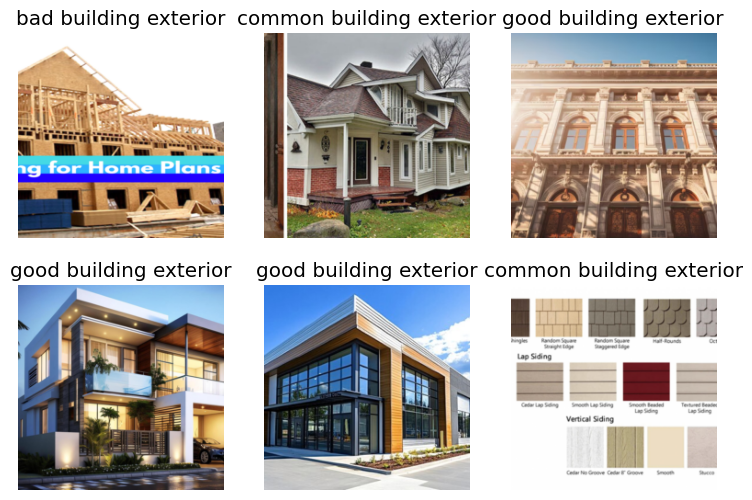

In [149]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224, ResizeMethod.Crop)).dataloaders(path)

dls.train.show_batch(max_n=6, nrows=2)

In [150]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Confusion matrix to see the error

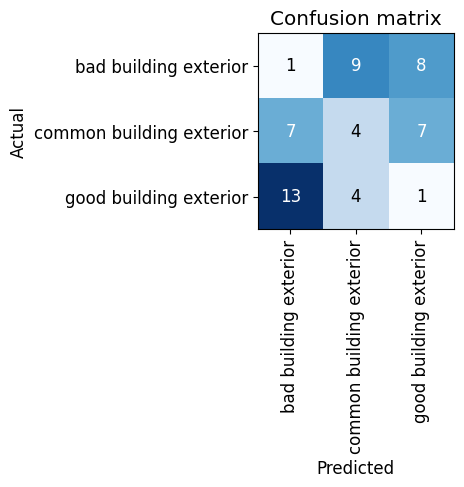

In [152]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

show the top losses

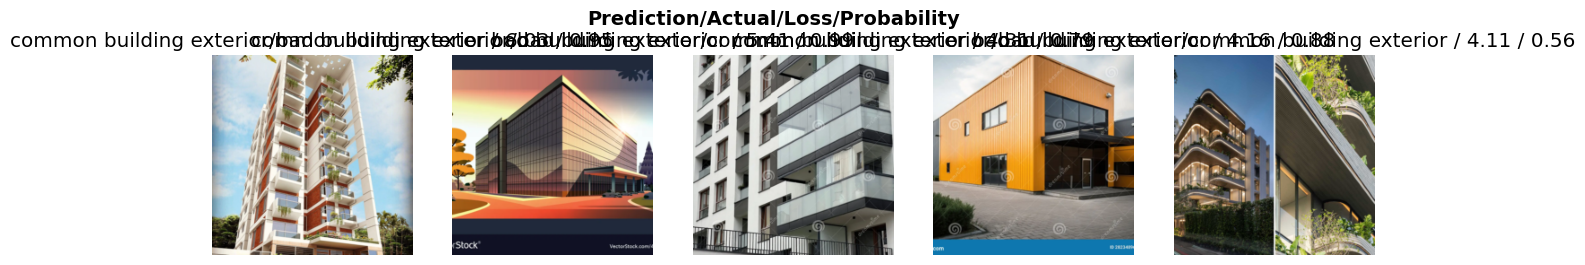

In [153]:
interp.plot_top_losses(5, nrows=1)

use data cleaner

In [155]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

test its ability of recognizing beautiful facades

In [161]:
is_good,_,probs = learn.predict(PILImage.create('images_test2.jpg'))
print(f"This is a: {is_good}.")
print(f"Probability it's a good facade: {probs[0]:.4f}")
#

This is a: good building exterior.
Probability it's a good facade: 0.2405


In [162]:
learn.export('facade_prediction.pkl')

##export

In [164]:
import gradio as gr

In [166]:
categories = ('good', 'bad', 'common')

def classify_image(img):
    pred,idx,probs = learn.predict(img)
    return dict(zip(categories, map(float,probs)))

In [169]:
image = gr.Image()
label = gr.Label()
examples = ['images_test1.jpg', 'images_test2.jpg']

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(inline=False)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://98ab9c8e3c5750b9b1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [171]:
import pandas as pd
import os

flagged_dir = 'flagged'
flagged_csv_path = os.path.join(flagged_dir, 'log.csv')

if os.path.exists(flagged_csv_path):
    flagged_df = pd.read_csv(flagged_csv_path)
    display(flagged_df)
else:
    print(f"No flagged data found yet. Flag some examples in the Gradio interface first. Looking for: {flagged_csv_path}")

No flagged data found yet. Flag some examples in the Gradio interface first. Looking for: flagged/log.csv
